In [55]:
#Part 1- Classify all symbols

#Load packages

#%pip install --upgrade pip

%pip install -q numpy emnist pandas matplotlib seaborn scikit-learn tensorflow xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow
import xgboost
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
REBUILD = True

import pkg_resources
installed_packages = pkg_resources.working_set
installed_packages_list = sorted(["%s==%s" % (i.key, i.version) for i in installed_packages])
print(installed_packages_list)


Note: you may need to restart the kernel to use updated packages.
['absl-py==2.1.0', 'annotated-types==0.6.0', 'anyio==4.2.0', 'appnope==0.1.3', 'argon2-cffi-bindings==21.2.0', 'argon2-cffi==23.1.0', 'arrow==1.3.0', 'asttokens==2.4.1', 'astunparse==1.6.3', 'async-lru==2.0.4', 'attrs==23.2.0', 'babel==2.14.0', 'beautifulsoup4==4.12.2', 'bleach==6.1.0', 'cachetools==5.3.2', 'certifi==2023.11.17', 'cffi==1.16.0', 'charset-normalizer==3.3.2', 'comm==0.2.1', 'contourpy==1.2.0', 'cycler==0.12.1', 'dacite==1.8.1', 'debugpy==1.8.0', 'decorator==5.1.1', 'defusedxml==0.7.1', 'emnist==0.0', 'executing==2.0.1', 'fastjsonschema==2.19.1', 'flatbuffers==23.5.26', 'fonttools==4.47.2', 'fqdn==1.5.1', 'gast==0.5.4', 'google-auth-oauthlib==1.2.0', 'google-auth==2.27.0', 'google-pasta==0.2.0', 'grpcio==1.60.1', 'h5py==3.10.0', 'htmlmin==0.1.12', 'idna==3.6', 'imagehash==4.3.1', 'ipykernel==6.28.0', 'ipython-genutils==0.2.0', 'ipython-sql==0.5.0', 'ipython==8.20.0', 'ipywidgets==8.1.1', 'isoduration==20.11

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/1471025653.py:39: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [24]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a  BINARY model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

    # Display metrics for a multi-class model
def display_metrics_multiclass(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(metrics_dict[task][model_name]['confusion_matrix'], index=symbols_list, columns=symbols_list)
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    sns.heatmap(cm_df, annot=True)

        # Display metrics for a multi-class trim
def display_metrics_multiclass_trim(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(metrics_dict[task][model_name]['confusion_matrix'], index=symbols_trim, columns=symbols_trim)
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    sns.heatmap(cm_df, annot=True)





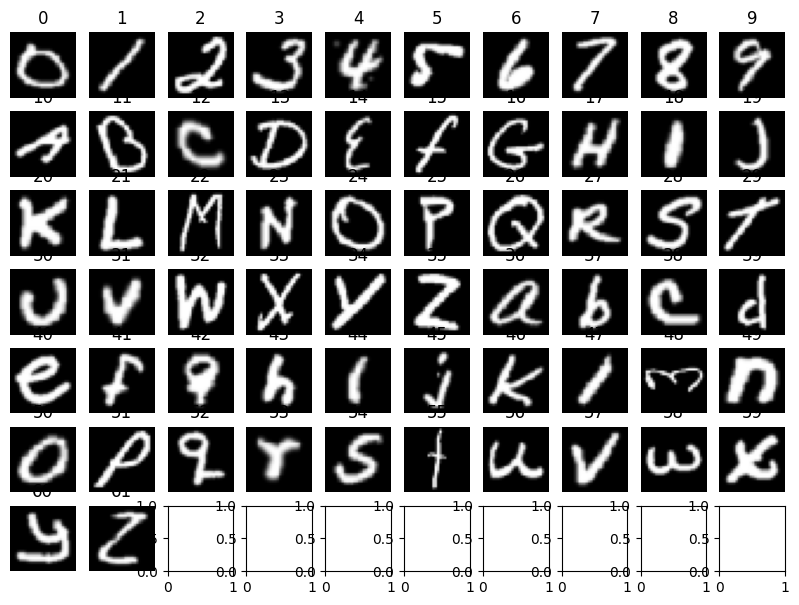

In [3]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label


# Get the first row for each label
firsts = train.groupby('label').first().reset_index()

# Build a plot with the first image for each label
fig, ax = plt.subplots(7, 10, figsize=(10, 7))
for i in range(62):
    ax[i//10, i%10].imshow(firsts['image'][i], cmap='gray')
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(firsts['label'][i])

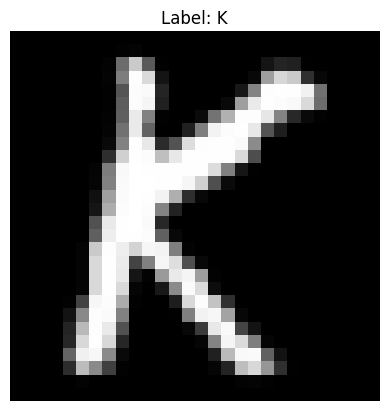

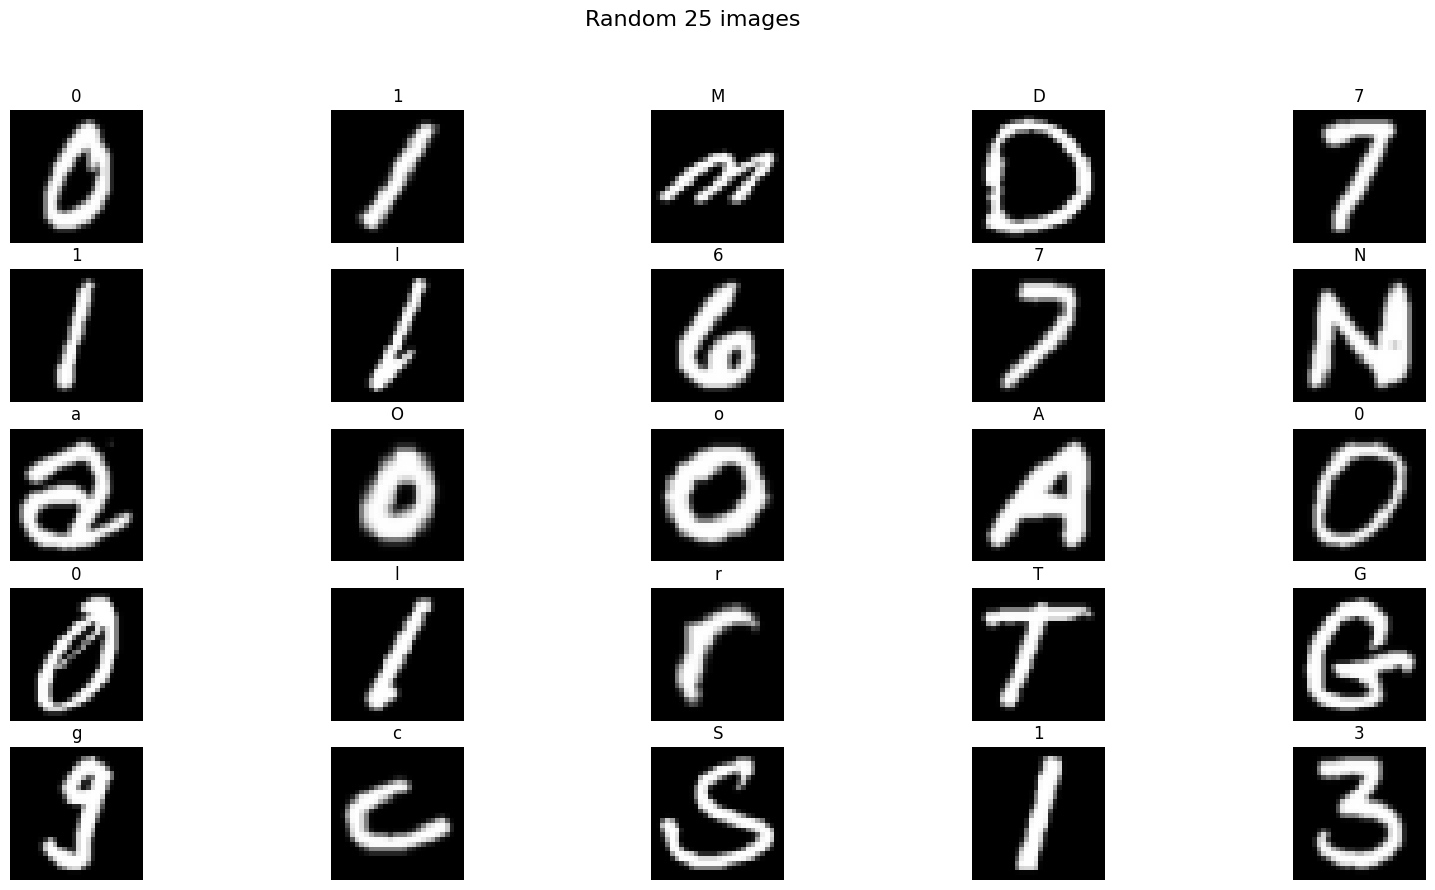

In [4]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?

In [8]:
#Quick Descriptive statistics- We had already explored the data in assignment #2, so I did not do a comprehensive exploratory analysis

#Get list of column name
print(train.columns. values. tolist())

#Print first 4 rows
#print(raw_train.head())
display(train.head())

#Identify number of rows and columns
print(train.shape)
print(valid.shape)

#Identify column types
column_types = train.dtypes
print(column_types)

#Assess for missing values in the train/valid set, of which there are none

missing_values = train.isnull().sum()
print(missing_values)

missing_values2 = valid.isnull().sum()
print(missing_values2)


['image', 'image_flat', 'label', 'class']


,image,image_flat,label,class
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M


(697932, 4)
(116323, 4)
image         object
image_flat    object
label          uint8
class         object
dtype: object
image         0
image_flat    0
label         0
class         0
dtype: int64
image         0
image_flat    0
label         0
class         0
dtype: int64


In [9]:
#Create a symbols list for the data

symbols_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

mask_train = train['class'].apply(lambda x: x in symbols_list)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}

# show_grid(train_01[:25], title="First 25 images of 0's and 1's")

In [10]:
 #(OPTIONAL) We can define all the metrics we want to track in a dictionary

#Note, the provided code was set up for a binary classifier. I have created an additional dictionary below for multi-class classification

metrics_dict = {
    '0_vs_1' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    },
    'multi-class classification' : { # multi-class classification. Note we will need multi-class classification for later problems
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [ ]:
#Question #1- Choose a model

# XGBoost

task = 'multi-class classification' #this needs to match the string used in the dictionary
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = xgb_clf.predict(valid_01['image_flat'].tolist())



#*********It was taking a really long time to run the hyper-parameter tuning, even on google colab, so eventually I de-prioritized this 
#This is the code that I would use to use cross-validattion for hyper-parameter tuning based on accuracy parameter:

# Initialize XGBoost classifier
#xgb_clf = XGBClassifier(random_state=42)

# Initialize GridSearchCV
#grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy') #In this case, the grid search was done based on accuracy. The CV validation selected was 3

# Perform grid search
#grid_search.fit(train_01['image_flat'].tolist(), train_01['label'])

# Get best parameters
#best_params = grid_search.best_params_
#print("Best Parameters:", best_params)

# Train final model with best parameters
#final_model = XGBClassifier(**best_params, random_state=42)
#final_model.fit(train_01['image_flat'].tolist(), train_01['label'])

# Evaluate final model
#accuracy = final_model.score(valid_01['image_flat'].tolist(), valid_01['label'])
#print("Validation Accuracy:", accuracy)



In [12]:
# Calculate performance metrics- there needs to be some kind of averaging argument specified as this is a multi-class classification problem
# "Macro" takes the unweighted mean scores for each class, which contributes equally to the final score, 
#regardless of its size or imbalance in the dataset.

acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred, average='macro')
rec = recall_score(valid_01['label'], y_pred, average='macro')
f1 = f1_score(valid_01['label'], y_pred, average='macro')
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.821892,0.721661,0.674658,0.688113


# Confusion Matrix: xgboost

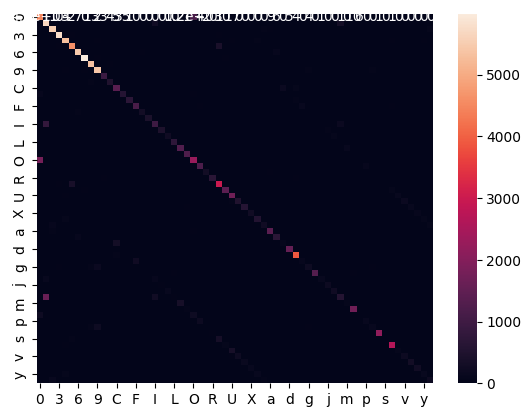

In [13]:
display_metrics_multiclass(task, model_name, metrics_dict)

In [14]:

#Function to identify the labels which have the poorest classification for removal as part of a sensitivity analysis.
#I have decided to threshold at 300 observations

def find_misclassifications_above_threshold(confusion_matrix, symbols_list, threshold=300):
    misclassifications = []
    for true_label_index in range(len(symbols_list)):
        for predicted_label_index in range(len(symbols_list)):
            if true_label_index != predicted_label_index:
                count = confusion_matrix[true_label_index, predicted_label_index]
                if count > threshold:
                    true_label = symbols_list[true_label_index]
                    predicted_label = symbols_list[predicted_label_index]
                    misclassifications.append((true_label, predicted_label, count))
    return misclassifications

misclassifications = find_misclassifications_above_threshold(cm, symbols_list, threshold=300)

print("Letters with greater than 300 misclassifications:")
for true_label, predicted_label, count in misclassifications:
    print(f"True label '{true_label}' predicted as '{predicted_label}': {count} times")


Letters with greater than 300 misclassifications:
True label '0' predicted as 'O': 1150 times
True label '1' predicted as 'l': 319 times
True label '5' predicted as 'S': 414 times
True label 'I' predicted as '1': 818 times
True label 'O' predicted as '0': 1795 times
True label 'S' predicted as '5': 384 times
True label 'c' predicted as 'C': 314 times
True label 'l' predicted as '1': 1628 times
True label 'm' predicted as 'M': 362 times
True label 's' predicted as 'S': 332 times
True label 'u' predicted as 'U': 356 times


In [15]:
#Next I will remove the poorest classified labels which include zero, O, l and 1, and I
symbols_trim = ['2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N','P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

#Important! We need to create a new integer index as we have removed "0" and "1", and so the integer placement now does not follow in sequence

new_label_function = lambda x: symbols_trim.index(x)

train['class_trim'] = train['class'].where(train['class'].astype(str).str.contains('|'.join(symbols_trim)), None)
train_clean = train[train['class_trim'].notnull()]
train_clean['label_trim'] = train_clean['class'].apply(new_label_function)

#Create another column with problem labels removed
valid['class_trim'] = valid['class'].where(valid['class'].astype(str).str.contains('|'.join(symbols_trim)), None)
valid_clean = valid[valid['class_trim'].notnull()]
valid_clean['label_trim'] = valid_clean['class'].apply(new_label_function)

display(train_clean)
display(valid_clean)

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/3838433960.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['label_trim'] = train_clean['class'].apply(new_label_function)
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/3838433960.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_clean['label_trim'] = valid_clean['class'].apply(new_label_function)


,image,image_flat,label,class,class_trim,label_trim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,Z,31
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,a,32
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,6,4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,3,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,M,19
...,...,...,...,...,...,...
697926,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23,N,N,20
697927,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,e,36
697929,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,5,3
697930,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,B,B,9


,image,image_flat,label,class,class_trim,label_trim
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,a,32
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,3,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",33,X,X,29
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,U,U,26
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,e,36
...,...,...,...,...,...,...
116317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,8,8,6
116318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,7,5
116319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,t,t,49
116320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,S,S,24


In [19]:

mask_train_trim = train_clean['class_trim'].apply(lambda x: x in symbols_trim) #masking is a method of indexing in pandas
train_trim = train_clean[mask_train_trim]
train_trim.reset_index(drop=True, inplace=True)

mask_valid_trim = valid_clean['class_trim'].apply(lambda x: x in symbols_trim)
valid_trim = valid_clean[mask_valid_trim]
valid_trim.reset_index(drop=True, inplace=True)



In [26]:
task = 'multi-class classification' #this needs to match the string used in the metrics dictionary
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train_trim['image_flat'].tolist(), train_trim['label_trim'])
y_pred_trim = xgb_clf.predict(valid_trim['image_flat'].tolist())


# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.867647,0.747438,0.709544,0.721596


# Confusion Matrix: xgboost

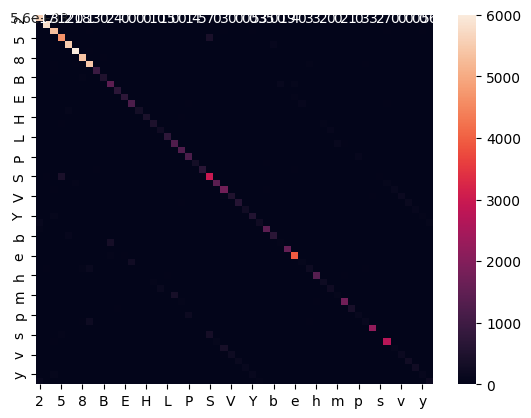

In [27]:
# Calculate performance metrics- 
acc = accuracy_score(valid_trim['label_trim'], y_pred_trim)
prec = precision_score(valid_trim['label_trim'], y_pred_trim, average='macro')
rec = recall_score(valid_trim['label_trim'], y_pred_trim, average='macro')
f1 = f1_score(valid_trim['label_trim'], y_pred_trim, average='macro')
cm = confusion_matrix(valid_trim['label_trim'], y_pred_trim)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

display_metrics_multiclass_trim(task, model_name, metrics_dict)

In [79]:
#Problem #2

#1. Create a column for whether each row is a digit or a letter

def class_cat(class_label):
    if class_label.isdigit():
        return "digit"
    else:
        return "letter"

    
train["class_bin"]= train["class"].apply(class_cat)
valid["class_bin"]= valid["class"].apply(class_cat)

display(train)

,image,image_flat,label,class,class_trim,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,Z,letter
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,a,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,6,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,3,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,M,letter
...,...,...,...,...,...,...
697927,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,e,letter
697928,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,None,letter
697929,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,5,digit
697930,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,B,B,letter


In [ ]:
#2. Choose an evaluation metric- eg. f1, accuracy, AUC, etc.

#I will focus on the f1 metric for model selection/prioritization, as it represents a more balanced overall assessment of model performance 
#(unlike accuracy, which can perform well, but have poor sensitivity) 
#However, I will generate the other standard metrics for practice.

In [ ]:
#3. Choose several candidate models to train

#Logistic regression, neural networks, xgboost, random forest (try them all)


In [80]:
merged_emnist = pd.concat([train, valid], axis=0) #merge together the two datasets, so can split up into different train/test sets
display(merged_emnist)

,image,image_flat,label,class,class_trim,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,Z,letter
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,a,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,6,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,3,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,M,letter
...,...,...,...,...,...,...
116318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,7,digit
116319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,t,t,letter
116320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,S,S,letter
116321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,None,digit


In [30]:
#4. Divide data to reserve a validation set that will NOT be used in training/testing

#I will use a 70/15/15 ratio for train/validation/and test datasets

#axis=0 means vertical stacking
merged_emnist = pd.concat([train, valid], axis=0)

# # Shuffle the rows of the merged DataFrame. (THis is especially important in clinical studies, as data collected at the 
#beginning of a study may be systematically different from that collected at the end of a study)
merged_emnist_shuffled = merged_emnist.sample(frac=1, random_state=42)

# Calculate sizes for train, validation, and test sets

#set aside a test set of 10% of total data
#Determine the length of test and "total train" data
total_train_size = int(0.90 * len(merged_emnist_shuffled))
test_size = len(merged_emnist_shuffled) - total_train_size

total_train_dataset = merged_emnist_shuffled.iloc[:total_train_size]
test_dataset = merged_emnist_shuffled.iloc[total_train_size:]

# Print the sizes of the resulting sets
print("Total Training set size:", len(total_train_dataset))
print("Test set size:", len(test_dataset))


Total Training set size: 732829
Test set size: 81426


In [31]:

#Create from the total training data, two train sets of 30%, and 2 test sets of 15%

train1_size = int(0.3 * len(total_train_dataset))
val1_size = int(0.15 * len(total_train_dataset))
train2_size = int(0.3 * len(total_train_dataset))
val2_size = int(0.15 * len(total_train_dataset))

# Split the shuffled DataFrame into train, validation, and test sets

# Creat first split for total_train_dataset
train1_dataset = total_train_dataset.iloc[:train1_size] #iloc is used to index by numerical indices, rather than by labels. 
#The "":"" means that we are indexing up to (be not including) the length of the total_train
val1_dataset = total_train_dataset.iloc[train1_size:train1_size+val1_size]

# Second split for total_train_dataset (to create train2_dataset and val2_dataset)
train2_dataset = total_train_dataset.iloc[train1_size+val1_size:train1_size+val1_size+train2_size]
val2_dataset = total_train_dataset.iloc[train1_size+val1_size+train2_size:]

# Print the sizes of the resulting sets
print("Train1 set size:", len(train1_dataset))
print("Val1 set size:", len(val1_dataset))
print("Train2 set size:", len(train2_dataset))
print("Val2 set size:", len(val2_dataset))



Train1 set size: 219848
Val1 set size: 109924
Train2 set size: 219848
Val2 set size: 183209


In [32]:
#Make sure the resulting datasets look appropriate

display(train1_dataset)

,image,image_flat,label,class,class_trim,class_bin
49883,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,7,NaN
315755,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,7,digit
127303,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",57,v,v,letter
48081,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,9,9,NaN
112324,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,3,NaN
...,...,...,...,...,...,...
335453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,C,C,letter
311632,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,None,letter
142719,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37,b,b,letter
623132,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,5,digit


In [33]:

#Filter data so includes only the rows including "digit" and "letter", which should include all observations in training and validation
#set based on this particular dataset (but perhaps not in datasets which have missing values)

symbols_bin = ['digit', 'letter']

#First set of train/validate
mask_train1_dataset = train1_dataset['class_bin'].apply(lambda x: x in symbols_bin)
train1_bin = train1_dataset[mask_train1_dataset]
train1_bin.reset_index(drop=True, inplace=True)

mask_valid1_dataset = val1_dataset['class_bin'].apply(lambda x: x in symbols_bin)
valid1_bin = val1_dataset[mask_valid1_dataset]
valid1_bin.reset_index(drop=True, inplace=True)


#Second set of train/validate
symbols_bin = ['digit', 'letter']

mask_train2_dataset = train2_dataset['class_bin'].apply(lambda x: x in symbols_bin)
train2_bin = train2_dataset[mask_train2_dataset]
train2_bin.reset_index(drop=True, inplace=True)

mask_valid2_dataset = val2_dataset['class_bin'].apply(lambda x: x in symbols_bin)
valid2_bin = val2_dataset[mask_valid2_dataset]
valid2_bin.reset_index(drop=True, inplace=True)


In [81]:
metrics_dict = {
    'digit_vs_letter' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [36]:
#RandomForest For 1st Set of Training/Validate Data

#I specified a "positive" label (1) as a "letter"

task = 'digit_vs_letter'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train1_bin['image_flat'].tolist(), train1_bin['class_bin'])
y_pred = rf_clf.predict(valid1_bin['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
rec = recall_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
f1 = f1_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.888129,0.900246,0.874757,0.887318


# Confusion Matrix: random_forest

,predicted 0,predicted 1
actual 0,42109,4591
actual 1,5932,41432


In [94]:

#This is the start of Emily's code

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, ParameterGrid, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming X_train, y_train are your training data and labels
# and X_val, y_val are your validation data and labels

# 1. Select candidate models, hyperparameter options, and evaluation metric
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'


In [96]:

# Splitting the dataset into training and validation sets

X = merged_emnist.drop(columns=['class_bin'])  # Features
y = merged_emnist['class_bin']  # Target variable

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [97]:
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Data splitting
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Models and specific parameter grids you want to test
models = [
    (RandomForestClassifier(), rf_param_grid),
    (XGBClassifier(), xgb_param_grid)
]

best_score = 0
best_model = None


In [98]:
for model, param_grid in models:
    for param_combination in ParameterGrid(param_grid):
        model.set_params(**param_combination)
        fold_scores = []
        
        # Split train using k-fold with the number of folds 
        # equal to the number of parameter combinations
        for train_index, test_index in kf.split(X_train):
            X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

            X_fold_train = np.array(X_fold_train)
            X_fold_test = np.array(X_fold_test)
            y_fold_train = np.array(y_fold_train)
            y_fold_test = np.array(y_fold_test)

            # Train the model on the training subset
            model.fit(X_fold_train.tolist(), y_fold_train)

            # Predict the labels for the test subset
            y_pred = model.predict(X_fold_test).tolist()

            # Evaluate the model's performance
            fold_score = accuracy_score(y_fold_test, y_pred)  # Example: Using accuracy as the performance metric
            fold_scores.append(fold_score)

        # Calculate the average score across all folds
        avg_score = np.mean(fold_scores)

        # Update the best score and model if the current model configuration performs better
        if avg_score > best_score:
            best_score = avg_score
            best_model = model.get_params()



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (521123, 5) + inhomogeneous part.

In [99]:
import numpy as np
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

symbols_bin = ['digit', 'letter']

rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'

# Define cross-validation strategy
kf = KFold(n_splits=5)  # Example: using 5-fold cross-validation

# Define the task and model name
task = 'digit_vs_letter'
model_name = 'random_forest'

# Initialize the metrics dictionary
metrics_dict[task] = {model_name: {}}

# Initialize best score and best model parameters
best_score = -np.inf
best_model = None

# Loop over parameter grid
for param_combination in ParameterGrid(param_grid):
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, **param_combination)
    fold_scores = []
    
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # Train the model on the training subset
        rf_clf.fit(X_fold_train, y_fold_train)

        # Predict the labels for the test subset
        y_pred = rf_clf.predict(X_fold_test)

        # Evaluate the model's performance
        fold_score = accuracy_score(y_fold_test, y_pred)
        fold_scores.append(fold_score)

    # Calculate the average score across all folds
    avg_score = np.mean(fold_scores)

    # Update the best score and model if the current model configuration performs better
    if avg_score > best_score:
        best_score = avg_score
        best_model = rf_clf

# Train and evaluate the best model on the entire validation set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_valid)

# Calculate performance metrics
acc = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred, pos_label='letter')
rec = recall_score(y_valid, y_pred, pos_label='letter')
f1 = f1_score(y_valid, y_pred, pos_label='letter')
cm = confusion_matrix(y_valid, y_pred)

# Store performance metrics in the dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}


TypeError: sklearn.ensemble._forest.RandomForestClassifier() got multiple values for keyword argument 'n_estimators'

In [100]:
import numpy as np
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

symbols_bin = ['digit', 'letter']

rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

scoring_metric = 'accuracy'

# Define cross-validation strategy
kf = KFold(n_splits=5)  # Example: using 5-fold cross-validation

# Define the task and model name
task = 'digit_vs_letter'
model_name = 'random_forest'

# Initialize the metrics dictionary
metrics_dict[task] = {model_name: {}}

# Initialize best score and best model parameters
best_score = -np.inf
best_model = None

# Loop over parameter grid
for param_combination in ParameterGrid(rf_param_grid):  # Fix this line
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, **param_combination)
    fold_scores = []
    
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # Train the model on the training subset
        rf_clf.fit(X_fold_train, y_fold_train)

        # Predict the labels for the test subset
        y_pred = rf_clf.predict(X_fold_test)

        # Evaluate the model's performance
        fold_score = accuracy_score(y_fold_test, y_pred)
        fold_scores.append(fold_score)

    # Calculate the average score across all folds
    avg_score = np.mean(fold_scores)

    # Update the best score and model if the current model configuration performs better
    if avg_score > best_score:
        best_score = avg_score
        best_model = rf_clf

# Train and evaluate the best model on the entire validation set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_valid)

# Calculate performance metrics
acc = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred, pos_label='letter')
rec = recall_score(y_valid, y_pred, pos_label='letter')
f1 = f1_score(y_valid, y_pred, pos_label='letter')
cm = confusion_matrix(y_valid, y_pred)

# Store performance metrics in the dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}


TypeError: sklearn.ensemble._forest.RandomForestClassifier() got multiple values for keyword argument 'n_estimators'

In [37]:
#Classifier: Logistic Regression for First Set of Training/Validate Data
task = 'digit_vs_letter'
model_name = 'logistic_regression'

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Scale the data
# When running without scaling the data, the model does not converge
scaler = StandardScaler()
train1_scaled = scaler.fit_transform(train1_bin['image_flat'].tolist())
valid1_scaled = scaler.transform(valid1_bin['image_flat'].tolist())

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate model
lr_clf.fit(train1_scaled, train1_bin['class_bin'])
y_pred = lr_clf.predict(valid1_scaled)

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
rec = recall_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
f1 = f1_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: logistic_regression

,accuracy,precision,recall,f1
0,0.73703,0.747506,0.721434,0.734239


# Confusion Matrix: logistic_regression

,predicted 0,predicted 1
actual 0,35158,11542
actual 1,13194,34170


In [38]:
#XG Boost for 1st set of Train/Validate Data

#The XG Boost did not like the outcome being stored as a string, so I converted to a numeric value, where
#letter=1 and digit = 0

#XGBoost
task = 'digit_vs_letter'
model_name = 'xgboost'

#Reassign the class_bin elements as numeric instead of string
train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
valid1_bin['class_bin'] = valid1_bin['class_bin'].replace({'letter': 1, 'digit': 0})


# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train1_bin['image_flat'].tolist(), train1_bin['class_bin'])
y_pred = xgb_clf.predict(valid1_bin['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred)
rec = recall_score(valid1_bin['class_bin'], y_pred)
f1 = f1_score(valid1_bin['class_bin'], y_pred)
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/2417853145.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/2417853145.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/2417853145.py:11: FutureWarning

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.874968,0.883678,0.865636,0.874564


# Confusion Matrix: xgboost

,predicted 0,predicted 1
actual 0,41303,5397
actual 1,6364,41000


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/1702742090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/1702742090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1_bin['class_bin'] = valid1_bin['class_bin'].replace({'letter': 1, 'digit': 0})


Epoch 1/10
5892/5892 [==============================] - 5s 721us/step - loss: 0.3267 - accuracy: 0.8520 - val_loss: 0.2793 - val_accuracy: 0.8786
Epoch 2/10
5892/5892 [==============================] - 4s 603us/step - loss: 0.2639 - accuracy: 0.8824 - val_loss: 0.2611 - val_accuracy: 0.8846
Epoch 3/10
5892/5892 [==============================] - 4s 611us/step - loss: 0.2449 - accuracy: 0.8915 - val_loss: 0.2518 - val_accuracy: 0.8886
Epoch 4/10
5892/5892 [==============================] - 4s 601us/step - loss: 0.2326 - accuracy: 0.8968 - val_loss: 0.2466 - val_accuracy: 0.8909
Epoch 5/10
5892/5892 [==============================] - 4s 613us/step - loss: 0.2228 - accuracy: 0.9004 - val_loss: 0.2502 - val_accuracy: 0.8915
Epoch 6/10
5892/5892 [==============================] - 4s 628us/step - loss: 0.2163 - accuracy: 0.9044 - val_loss: 0.2464 - val_accuracy: 0.8932
Epoch 7/10
5892/5892 [==============================] - 4s 609us/step - loss: 0.2106 - accuracy: 0.9062 - val_loss: 0.2435 -

# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.892286,0.890649,0.896103,0.893368


# Confusion Matrix: neural_network

,predicted 0,predicted 1
actual 0,41489,5211
actual 1,4921,42443


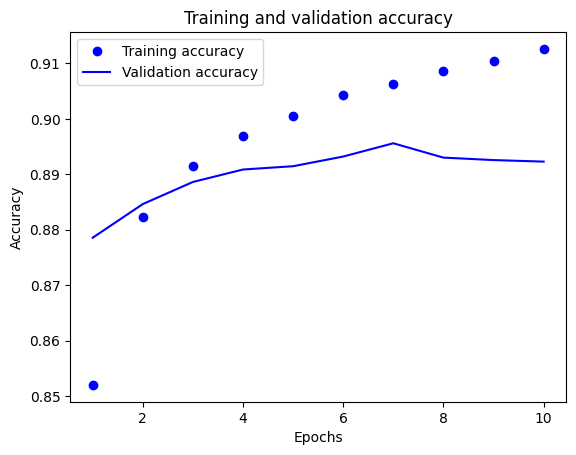

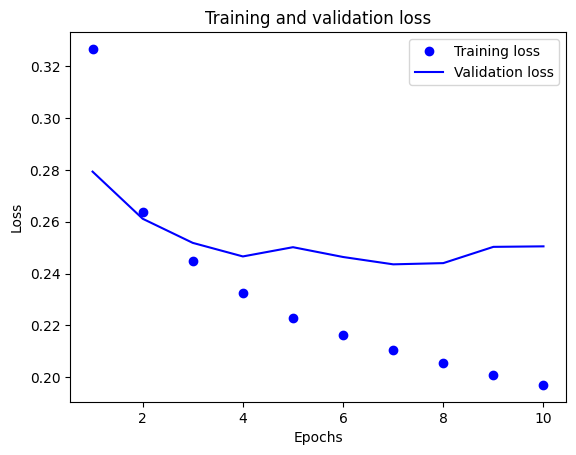

In [39]:
#  Neural Network for First Set of Training/Test Data
task = 'digit_vs_letter'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
valid1_bin['class_bin'] = valid1_bin['class_bin'].replace({'letter': 1, 'digit': 0})

# Convert data to tensor
train_images = np.array(train1_bin['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train1_bin['class_bin'])
valid_images = np.array(valid1_bin['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid1_bin['class_bin'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred)
rec = recall_score(valid1_bin['class_bin'], y_pred)
f1 = f1_score(valid1_bin['class_bin'], y_pred)
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

In [40]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)

accuracy  precision    recall        f1  \
model           metric                                                         
digit_vs_letter random_forest        0.888129   0.900246  0.874757  0.887318   
                logistic_regression  0.737030   0.747506  0.721434  0.734239   
                xgboost              0.874968   0.883678  0.865636  0.874564   
                neural_network       0.892286   0.890649  0.896103  0.893368   

                                                     confusion_matrix  
model           metric                                                 
digit_vs_letter random_forest          [[42109, 4591], [5932, 41432]]  
                logistic_regression  [[35158, 11542], [13194, 34170]]  
                xgboost                [[41303, 5397], [6364, 41000]]  
                neural_network         [[41489, 5211], [4921, 42443]]

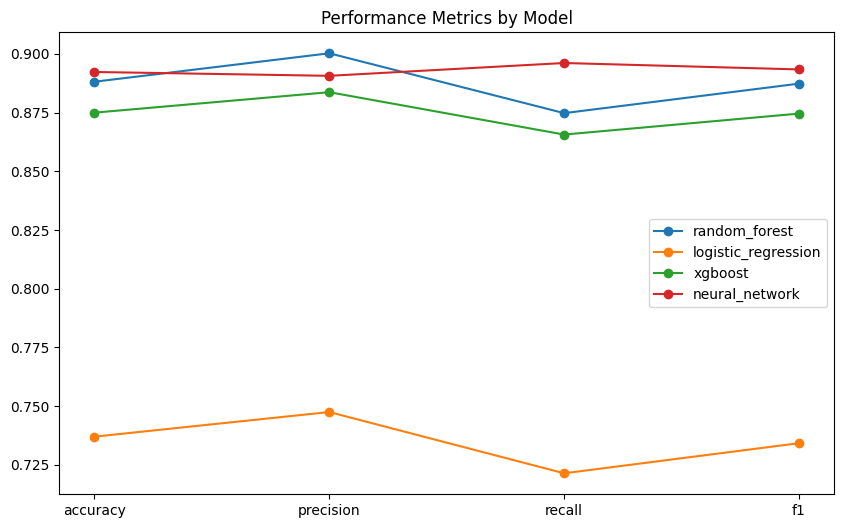

In [41]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['digit_vs_letter'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['digit_vs_letter'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()

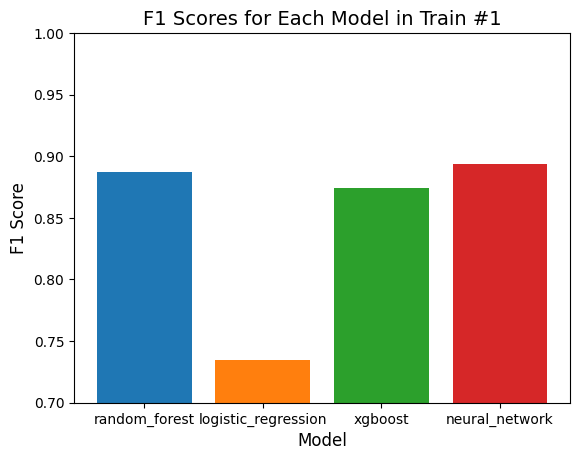

In [42]:
models = ['random_forest', 'logistic_regression',"xgboost","neural_network"]
accuracies = [metrics_dict['digit_vs_letter'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model in Train #1', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.7, 1.0])
plt.show()


In [43]:
#Will pick the neural network and random forest to assess train/test split #2

#RandomForest For 2st Set of Training/Test Data

#I specified a "positive" label (1) as a "letter"


task = 'digit_vs_letter'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train2_bin['image_flat'].tolist(), train2_bin['class_bin'])
y_pred = rf_clf.predict(valid2_bin['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid2_bin['class_bin'], y_pred)
prec = precision_score(valid2_bin['class_bin'], y_pred, pos_label='letter')
rec = recall_score(valid2_bin['class_bin'], y_pred, pos_label='letter')
f1 = f1_score(valid2_bin['class_bin'], y_pred, pos_label='letter')
cm = confusion_matrix(valid2_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.889544,0.902829,0.876138,0.889283


# Confusion Matrix: random_forest

,predicted 0,predicted 1
actual 0,70015,7496
actual 1,9846,69646


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/338514267.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train2_bin['class_bin'] = train2_bin['class_bin'].replace({'letter': 1, 'digit': 0})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/338514267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2_bin['class_bin'] = train2_bin['class_bin'].replace({'letter': 1, 'digit': 0})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/338514267.py:9: FutureWarning: Down

Epoch 1/10
5890/5890 [==============================] - 5s 838us/step - loss: 0.3286 - accuracy: 0.8511 - val_loss: 0.2776 - val_accuracy: 0.8779
Epoch 2/10
5890/5890 [==============================] - 4s 697us/step - loss: 0.2657 - accuracy: 0.8821 - val_loss: 0.2584 - val_accuracy: 0.8852
Epoch 3/10
5890/5890 [==============================] - 4s 686us/step - loss: 0.2464 - accuracy: 0.8908 - val_loss: 0.2494 - val_accuracy: 0.8898
Epoch 4/10
5890/5890 [==============================] - 4s 703us/step - loss: 0.2342 - accuracy: 0.8962 - val_loss: 0.2472 - val_accuracy: 0.8921
Epoch 5/10
5890/5890 [==============================] - 4s 703us/step - loss: 0.2259 - accuracy: 0.8995 - val_loss: 0.2426 - val_accuracy: 0.8938
Epoch 6/10
5890/5890 [==============================] - 4s 698us/step - loss: 0.2189 - accuracy: 0.9027 - val_loss: 0.2423 - val_accuracy: 0.8937
Epoch 7/10
5890/5890 [==============================] - 4s 706us/step - loss: 0.2129 - accuracy: 0.9050 - val_loss: 0.2455 -

# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.893365,0.909467,0.876654,0.892759


# Confusion Matrix: neural_network

,predicted 0,predicted 1
actual 0,70574,6937
actual 1,9805,69687


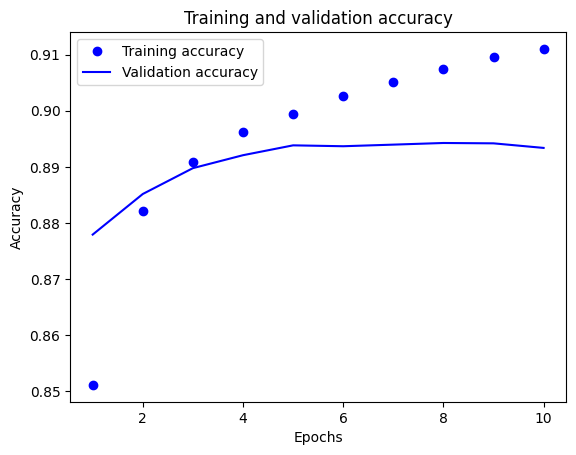

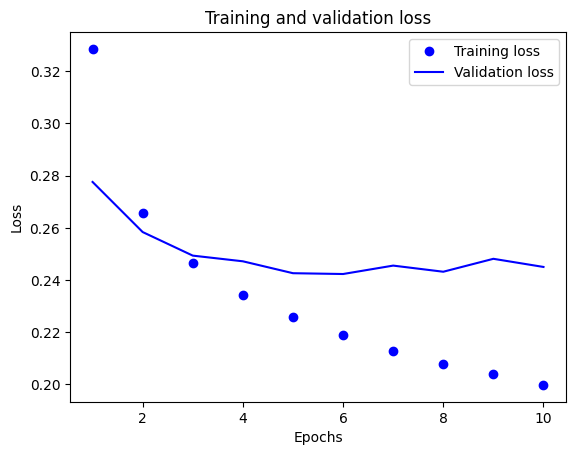

In [44]:
#  Neural Network for 2nd Set of Training/Test Data
task = 'digit_vs_letter'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

train2_bin['class_bin'] = train2_bin['class_bin'].replace({'letter': 1, 'digit': 0})
valid2_bin['class_bin'] = valid2_bin['class_bin'].replace({'letter': 1, 'digit': 0})

# Convert data to tensor
train_images = np.array(train2_bin['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train2_bin['class_bin'])
valid_images = np.array(valid2_bin['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid2_bin['class_bin'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
acc = accuracy_score(valid2_bin['class_bin'], y_pred)
prec = precision_score(valid2_bin['class_bin'], y_pred)
rec = recall_score(valid2_bin['class_bin'], y_pred)
f1 = f1_score(valid2_bin['class_bin'], y_pred)
cm = confusion_matrix(valid2_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

neural_network_model2= model

In [45]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)

accuracy  precision    recall        f1  \
model           metric                                                    
digit_vs_letter random_forest   0.889544   0.902829  0.876138  0.889283   
                neural_network  0.893365   0.909467  0.876654  0.892759   

                                              confusion_matrix  
model           metric                                          
digit_vs_letter random_forest   [[70015, 7496], [9846, 69646]]  
                neural_network  [[70574, 6937], [9805, 69687]]

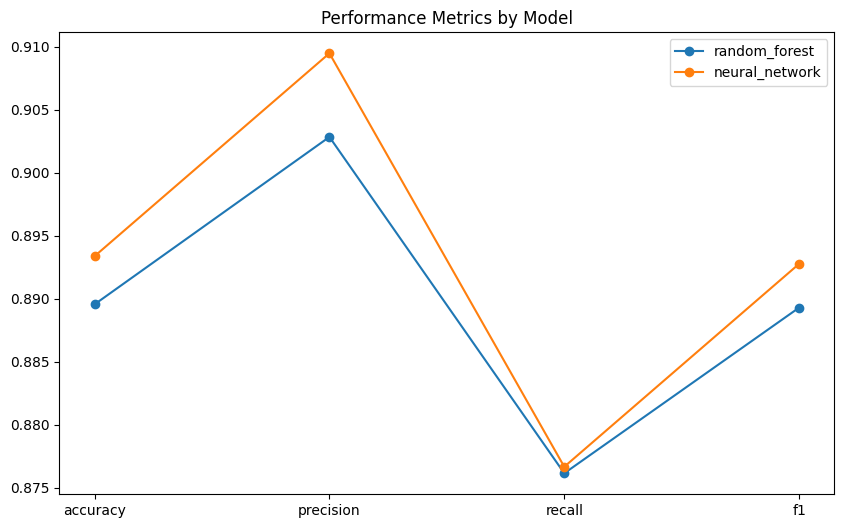

In [46]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['digit_vs_letter'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['digit_vs_letter'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()

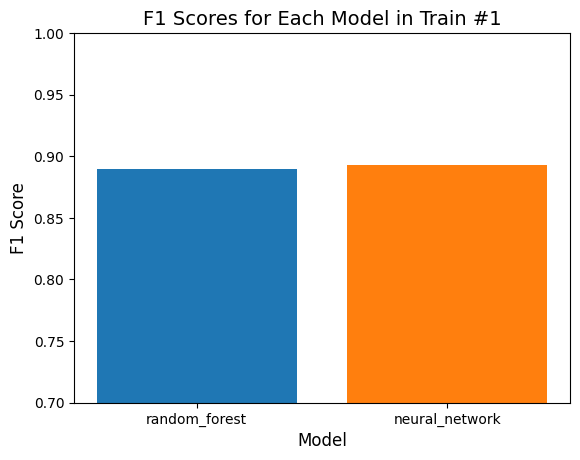

In [47]:
models = ['random_forest',"neural_network"]
accuracies = [metrics_dict['digit_vs_letter'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model in Train #1', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.7, 1.0])
plt.show()


In [321]:
display(test_dataset)
missing_values3 = test_dataset.isnull().sum()
print(missing_values3)

# Check for missing values in the class column
missing_values_class_bin = test_dataset['class_bin'].isnull().sum()
#print("Missing values in the class column:", missing_values_class)
print("Missing values in the class_bin column:", missing_values_class_bin)




,image,image_flat,label,class,class_bin2,class_bin
643018,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,1,1
226830,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,1,0
762,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43,h,1,1
540545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,1,0
50800,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,R,1,1
...,...,...,...,...,...,...
259178,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,H,1,1
365838,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,O,1,1
131932,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,1,0
671155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",53,r,1,1


image         0
image_flat    0
label         0
class         0
class_bin2    0
class_bin     0
dtype: int64
Missing values in the class_bin column: 0


In [48]:
#Create the class_bin column in the test dataset

test_dataset["class_bin"]= test_dataset["class"].apply(class_cat)
display(test_dataset.head())


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/3190046585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset["class_bin"]= test_dataset["class"].apply(class_cat)


,image,image_flat,label,class,class_trim,class_bin
643018,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,None,letter
226830,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,7,digit
762,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43,h,h,letter
540545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,None,digit
50800,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,R,R,letter


In [51]:


task = 'digit_vs_letter'
model_name = 'neural_network'

#Need to define test images and test labels
test_images = np.array(test_dataset['image'])
test_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), test_images)))
test_images = test_images / 255.0
test_labels = np.array(test_dataset['class_bin'])

# Convert class labels to numeric format
test_dataset['class_bin'] = test_dataset['class_bin'].replace({'letter': 1, 'digit': 0})
test_labels_encoded = test_dataset['class_bin'].astype(np.float32)

# Evaluate the model on the test dataset
loss, accuracy = neural_network_model2.evaluate(test_images, test_labels_encoded)
print("Independent Dataset Loss:", loss)
print("Independent Dataset Accuracy:", accuracy)

# Make predictions on the independent dataset
y_pred_independent = (neural_network_model2.predict(test_images) > 0.5).astype(int).flatten()


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_14827/770696403.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['class_bin'] = test_dataset['class_bin'].replace({'letter': 1, 'digit': 0})


[0. 1.]
float32
2545/2545 [==============================] - 1s 305us/step - loss: 0.2436 - accuracy: 0.8948
Independent Dataset Loss: 0.2436298280954361
Independent Dataset Accuracy: 0.8948001861572266
2545/2545 [==============================] - 1s 297us/step


In [54]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have already defined task and model_name variables

# Calculate performance metrics for the independent dataset
acc_independent = accuracy_score(test_labels_encoded, y_pred_independent)
prec_independent = precision_score(test_labels_encoded, y_pred_independent)
rec_independent = recall_score(test_labels_encoded, y_pred_independent)
f1_independent = f1_score(test_labels_encoded, y_pred_independent)
cm_independent = confusion_matrix(test_labels_encoded, y_pred_independent)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {
    'accuracy': acc_independent,
    'precision': prec_independent,
    'recall': rec_independent,
    'f1': f1_independent,
    'confusion_matrix': cm_independent
}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)



# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.8948,0.911329,0.877127,0.893901


# Confusion Matrix: neural_network

,predicted 0,predicted 1
actual 0,36775,3511
actual 1,5055,36085
